## What is siuba?

In [1]:
from siuba import _, group_by, summarize, filter
from siuba.data import mtcars

(mtcars
  >> group_by(_.cyl)
  >> summarize(avg_hp = _.hp.mean())
  )

,cyl,avg_hp
0,4,82.636364
1,6,122.285714
2,8,209.214286


In [2]:
mtcars.agg({'hp': lambda _: _.mean()})

hp    146.6875
dtype: float64

In [3]:
mtcars.groupby(['cyl']).agg({'hp': lambda _: _.mean()})

,hp
cyl,
4,82.636364
6,122.285714
8,209.214286


## Bob Ross Analysis

In [4]:
import pandas as pd
from siuba import *
from plotnine import *

%load_ext blackcellmagic

import matplotlib.cbook

import warnings
import plotnine
warnings.filterwarnings(module='plotnine*', action='ignore')
warnings.filterwarnings(module='matplotlib*', action='ignore')

%matplotlib inline

bob_ross = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-08-06/bob-ross.csv")

In [5]:
tidy_bob = bob_ross >> gather("tag", "value", _["APPLE_FRAME":]) >> filter(_.value == 1)

tidy_bob.columns = tidy_bob.columns.str.lower()

In [6]:
bob_ross.shape

(403, 69)

In [7]:
tidy_bob >> count(_.episode, _.title, sort = True) >> head(3)

,episode,title,n
0,S10E09,"""MOUNTAIN OVAL""",15
1,S02E04,"""SHADES OF GREY""",14
2,S04E04,"""WINTER SAWSCAPE""",14


In [8]:
tidy_bob >> count(_.tag, sort = True) >> head(5)

,tag,n
0,TREE,361
1,TREES,337
2,DECIDUOUS,227
3,CONIFER,212
4,CLOUDS,179


In [9]:
tidy_bob >> count(_.value)

,value,n
0,1,3221


### Episodes can have the same titles

In [10]:
bob_ross >> filter(_.TITLE == '"LAKESIDE CABIN"')

,EPISODE,TITLE,APPLE_FRAME,AURORA_BOREALIS,BARN,BEACH,BOAT,BRIDGE,BUILDING,BUSHES,...,TOMB_FRAME,TREE,TREES,TRIPLE_FRAME,WATERFALL,WAVES,WINDMILL,WINDOW_FRAME,WINTER,WOOD_FRAMED
92,S08E02,"""LAKESIDE CABIN""",0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0
129,S10E13,"""LAKESIDE CABIN""",0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


### Most common tags

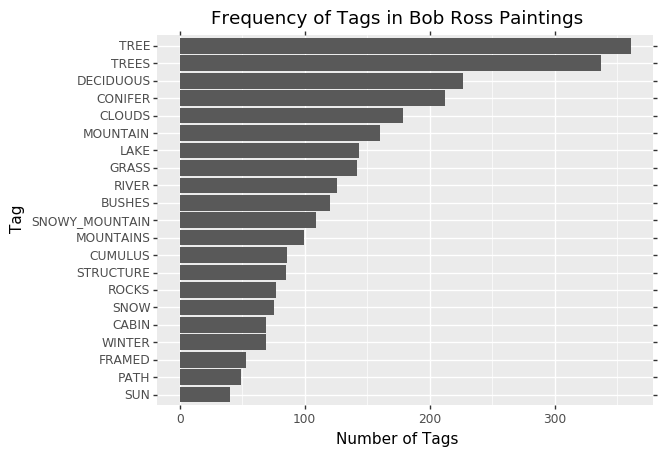

<ggplot: (307313840)>

In [11]:
from siuba.dply.forcats import fct_reorder

(tidy_bob
    >> count(_.tag, sort=True)
    >> mutate(tag=fct_reorder(_.tag, _.n))
    >> filter(_.n > 39)
    >> ggplot(aes("tag", "n"))
    + geom_col()
    + coord_flip()
    + labs(title="Frequency of Tags in Bob Ross Paintings", x="Tag", y="Number of Tags")
    )

### Cond probability of trees (do trees have friends?)

p(trees | tree) = p(tree AND trees) / p(tree)

In [12]:
tidy_bob >> count(_.tag) >> filter(_.tag.isin(["TREE", "TREES"]))

,tag,n
57,TREE,361
58,TREES,337


In [13]:
print(round(337 / 361, 2))

bob_ross >> filter(_.TREE == 1, _.TREES == 1) >> count()

0.93


,n
0,337


### Most common word in painting titles

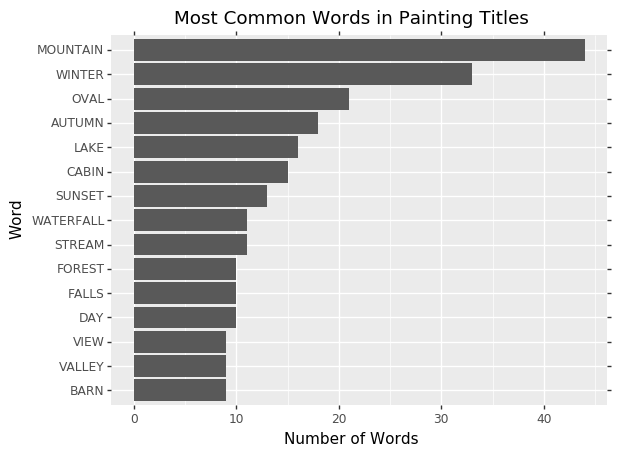

<ggplot: (310343905)>

In [14]:
title_word_count = (
    bob_ross
    >> select(_.EPISODE, _.TITLE)
    >> mutate(word=_.TITLE.str.split(" "))
    >> unnest("word")
    >> mutate(word=_.word.str.replace('"', ""))
    >> filter(~_.word.isin(["THE", "OF", "IN", "AT", "A"]))
    >> count(_.word, sort=True)
)

(
    title_word_count
    >> head(15)
    >> mutate(word=fct_reorder(_.word, _.n))
    >> ggplot(aes("word", "n"))
    + geom_col()
    + coord_flip()
    + labs(title="Most Common Words in Painting Titles", x="Word", y="Number of Words")
)

### Tags grouped by season

In [15]:
from siuba.dply.vector import row_number

grouped_bob = tidy_bob >> mutate(
    season_num=_.episode.str.extract("S([0-9]+)E([0-9]+)").loc[:, 0].astype(int),
    episode_num=_.episode.str.extract("S([0-9]+)E([0-9]+)").loc[:, 1].astype(int),
)

(
    grouped_bob
    >> count(_.season_num, _.tag)
    >> arrange(_.season_num, -_.n)
    >> group_by(_.season_num)
    >> mutate(rank = _.n.rank(method = "dense", ascending = False).astype(int))
    >> filter(_["rank"] < 4)
    >> ungroup()
    >> count(_.tag, sort = True)
)

,tag,n
0,TREE,31
1,TREES,31
2,DECIDUOUS,18
3,CONIFER,15
4,CLOUDS,10
5,RIVER,5
6,LAKE,4
7,GRASS,3
8,MOUNTAIN,3
9,BUSHES,2
